# Data Preprocessing

* Generate These Tables:
  * Merchant Order table
  * Merchant Product table
  * Time Series purchase, client table

In [91]:
import pandas as pd
from datetime import date, timedelta
import random
import numpy as np

## Understand Data

* Raw data is downloaded from
  * https://www.kaggle.com/c/instacart-market-basket-analysis/data
  * https://en.wikipedia.org/wiki/List_of_supermarket_chains_in_Canada

In [2]:
products_df = pd.read_csv('products.csv')
print(products_df.shape)

products_df.head()

(49688, 4)


product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [3]:
departments_df = pd.read_csv('departments.csv')
print(departments_df.shape)

departments_df.head()

(21, 2)


department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [4]:
aisles_df = pd.read_csv('aisles.csv')
print(aisles_df.shape)

aisles_df.head()

(134, 2)


aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [5]:
# order_dow is the day of the week
orders_df = pd.read_csv('orders.csv')
print(orders_df.shape)

orders_df.head()

(3421083, 7)


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [7]:
order_prior_df = pd.read_csv('order_products__prior.csv')
print(order_prior_df.shape)

order_prior_df.head()

(32434489, 4)


order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [8]:
order_train_df = pd.read_csv('order_products__train.csv')
print(order_train_df.shape)

order_train_df.head()

(1384617, 4)


order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

## Utils

In [76]:
def get_monday_lst(year):
    d = date(year, 2, 17)    
    d += timedelta(days = 0 - d.weekday())  # First Monday
    while d.year == year and d.month < 5:
        yield d
        d += timedelta(days = 7)

        
def uniform_random_select(lst, const):
    rand = random.randint(0, const%len(lst))
    return lst[rand]


#  Assign a purchase date to each order
monday_seeds = list(get_monday_lst(2020))
user_startingdate_dct = {}
def assign_date(r):
    user_id = r[1]
    days_since_prior_order = r[2]
    order_dow = r[3]
    
    if np.isnan(days_since_prior_order):
        row_date = uniform_random_select(monday_seeds, user_id) + timedelta(days = order_dow)
        user_startingdate_dct[user_id] = row_date
    else:
        row_date = user_startingdate_dct[user_id] + timedelta(days = days_since_prior_order)
        
    r = r.append(row_date)

## Merchant Order Table

In [62]:
# unit both prior and train orders
order_prior_train_df = order_prior_df.append(order_train_df)
print(order_prior_train_df.shape)

(33819106, 4)


In [64]:
order_prod_df = orders_df.merge(order_prior_train_df, on='order_id')
order_prod_df = order_prod_df.sort_values(by=['user_id', 'order_number'])
print(order_prod_df.shape)

order_prod_df.head()

(33819106, 10)


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  
0                     NaN         196                  1          0  
1                     NaN       14084                  2          0  
2                     NaN       12427                  3          0  
3                     NaN       26088                  4          0  
4                     NaN       26405                  5          0

### Add purchase_date

* For each order in each user, assign a random date but in time order listed in "days_since_prior_order".
* Random number is uniform distribution.

In [135]:
user_group_df = order_prod_df[['order_id', 'user_id', 'days_since_prior_order', 'order_dow', 'order_number']].drop_duplicates()
user_group_df = user_group_df.sort_values(by=['user_id', 'order_number'])

print(user_group_df.shape)

user_group_df.head()

(3346083, 5)


order_id  user_id  days_since_prior_order  order_dow  order_number
0    2539329        1                     NaN          2             1
5    2398795        1                    15.0          3             2
11    473747        1                    21.0          3             3
16   2254736        1                    29.0          4             4
21    431534        1                    28.0          4             5

In [124]:
# Using a list is faster
user_group_records = user_group_df.values.tolist()

for r in user_group_records:
    assign_date(r)
    
print (user_group_records[0:4])

[[2539329.0, 1.0, nan, 2.0, 1.0, datetime.date(2020, 2, 26)], [2398795.0, 1.0, 15.0, 3.0, 2.0, datetime.date(2020, 3, 12)], [473747.0, 1.0, 21.0, 3.0, 3.0, datetime.date(2020, 3, 18)], [2254736.0, 1.0, 29.0, 4.0, 4.0, datetime.date(2020, 3, 26)]]


In [125]:
user_group_df = pd.DataFrame(user_group_records)
user_group_df.columns = ['order_id', 'user_id', 'days_since_prior_order', 'order_dow', 'order_number', 'purchase_date']
user_group_df.head()

order_id  user_id  days_since_prior_order  order_dow  order_number  \
0  2539329.0      1.0                     NaN        2.0           1.0   
1  2398795.0      1.0                    15.0        3.0           2.0   
2   473747.0      1.0                    21.0        3.0           3.0   
3  2254736.0      1.0                    29.0        4.0           4.0   
4   431534.0      1.0                    28.0        4.0           5.0   

  purchase_date  
0    2020-02-26  
1    2020-03-12  
2    2020-03-18  
3    2020-03-26  
4    2020-03-25

In [127]:
order_prod_df = order_prod_df.merge(user_group_df[['order_id', 'purchase_date']], on='order_id')
print(order_prod_df.shape)

order_prod_df.head()

(33819106, 11)


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN         196                  1          0   
1                     NaN       14084                  2          0   
2                     NaN       12427                  3          0   
3                     NaN       26088                  4          0   
4                     NaN       26405                  5          0   

  purchase_date  
0    2020-02-26  
1    2020-02-26  
2    2020-02-26  
3    2020-02-26  
4    2020-02-26

### Add merchant

* Randomly assign merchant for each order_id.
* Random number is in normal distribution.

In [139]:
merchant_lst = ["49th Parallel Grocery", "Asian Food Centre", "Askew's Foods", "Avril (Health Supermarket)", "Coleman's",
                "Co-op Atlantic", "Valu Foods", "Village Food Stores", "Coppa's Fresh Market", "Country Grocer",
                "Fairway Markets", "Family Foods", "Calgary Co-op", "North Central Co-op", "Red River Co-op",
                "Saskatoon Co-op", "Foodex", "FoodFare", "Fresh City Market", "Freson Bros.", "Galleria Supermarkets",
                "Goodness me", "H Mart", "Highland Farms", "Kim Phat", "Le Jardin Mobile", "L&M Markets (Hometown Grocers Co-op)",
                "Lalumière Bonanza", "Longo's", "Marché Frais", "Le Marché Esposito", "Les Arpents Verts", "Lococo's",
                "Lucky Supermarket", "Mike Dean's Super Food Stores", "Nations Fresh Food", "Nature's Emporium",
                "Northern", "NorthMart", "Panchvati Supermarket", "P.A.T. Mart", "Planet Organic", "Pomme Natural Market",
                "Rabba Fine Foods", "Subzi Mandi Cash & Carry", "Quality Foods", "Sunterra Market", "TaiKo Supermarket",
                "Vince's Market"]
len(merchant_lst)

49

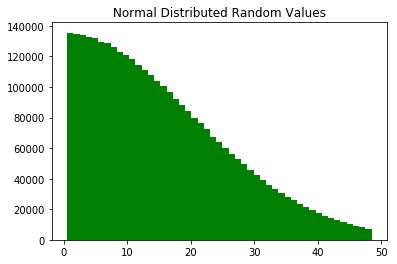

In [162]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.5, len(merchant_lst))
xU, xL = x + 0.5, x - 0.5 
prob = ss.norm.cdf(xU, scale = 20) - ss.norm.cdf(xL, scale = 20)
prob = prob / prob.sum() #normalize the probabilities so their sum is 1
nums = np.random.choice(x, size = order_prod_df['order_id'].nunique(), p = prob)
plt.hist(nums, bins = len(x), color='g')
plt.title('Normal Distributed Random Values')
plt.show()

In [163]:
print(int(min(nums)), int(max(nums)))

0 48


In [164]:
# order_id list
orderid_lst = order_prod_df['order_id'].unique()

order_merchant_records = []
for i in range(len(orderid_lst)):
    orderid = orderid_lst[i]
    merchant = merchant_lst[int(nums[i])]
    order_merchant_records.append([orderid, merchant])
    
order_merchant_df = pd.DataFrame(order_merchant_records)
order_merchant_df.columns = ['order_id', 'merchant']
order_merchant_df.head()

order_id                       merchant
0   2539329                         Foodex
1   2398795                 Highland Farms
2    473747           Coppa's Fresh Market
3   2254736              Fresh City Market
4    431534  Mike Dean's Super Food Stores

In [167]:
order_prod_df = order_prod_df.merge(order_merchant_df, on='order_id')
print(order_prod_df.shape)
order_prod_df.head()

(33819106, 12)


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN         196                  1          0   
1                     NaN       14084                  2          0   
2                     NaN       12427                  3          0   
3                     NaN       26088                  4          0   
4                     NaN       26405                  5          0   

  purchase_date merchant  
0    2020-02-26   Foodex  
1    2020-02-26   Foodex  
2    2020-02-26   Foodex  
3    2020-02-26   Foodex  
4    2020-02-26   Foodex

In [170]:
order_prod_df.drop(['eval_set', 'order_dow', 'days_since_prior_order', 'reordered', 'add_to_cart_order'], 
                   inplace=True, axis=1)
order_prod_df.head()

order_id  user_id  order_number  order_hour_of_day  product_id  \
0   2539329        1             1                  8         196   
1   2539329        1             1                  8       14084   
2   2539329        1             1                  8       12427   
3   2539329        1             1                  8       26088   
4   2539329        1             1                  8       26405   

  purchase_date merchant  
0    2020-02-26   Foodex  
1    2020-02-26   Foodex  
2    2020-02-26   Foodex  
3    2020-02-26   Foodex  
4    2020-02-26   Foodex

In [172]:
order_prod_df.to_pickle('merchant_order.pkl')